In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 18

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [4]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [5]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [11]:
runs = [304125,302263,304508]
with open("pileup_dataNotNorm.pickle", 'rb') as handle:
    data = pickle.load(handle)
with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])

WINDOW = 1
num_parts = 6

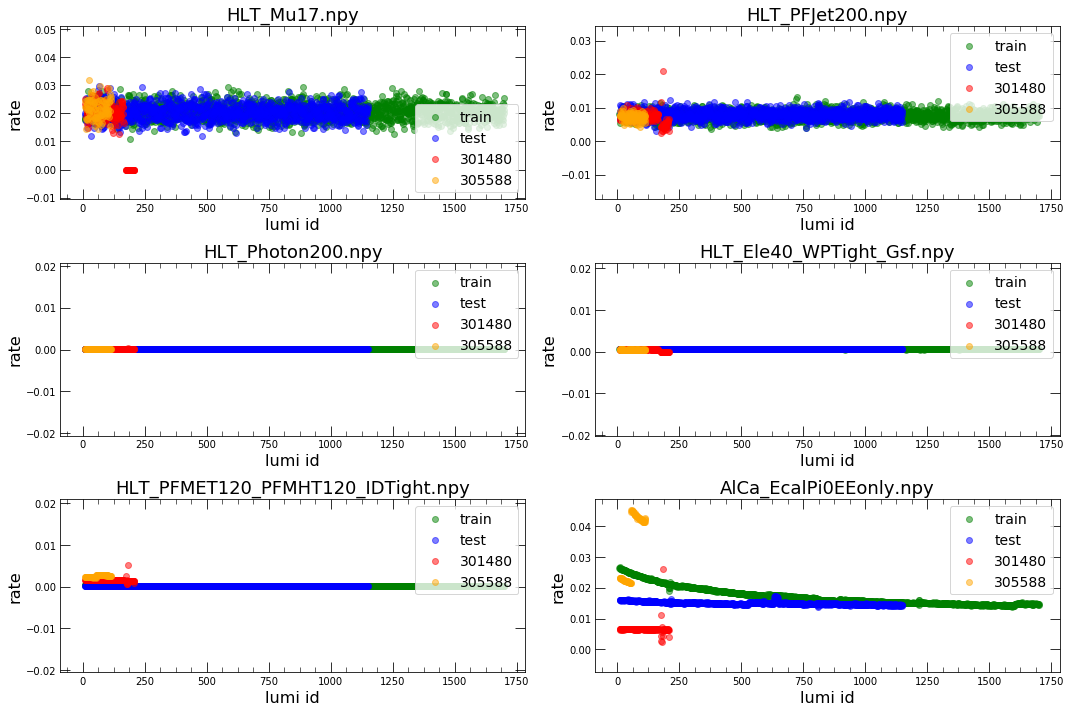

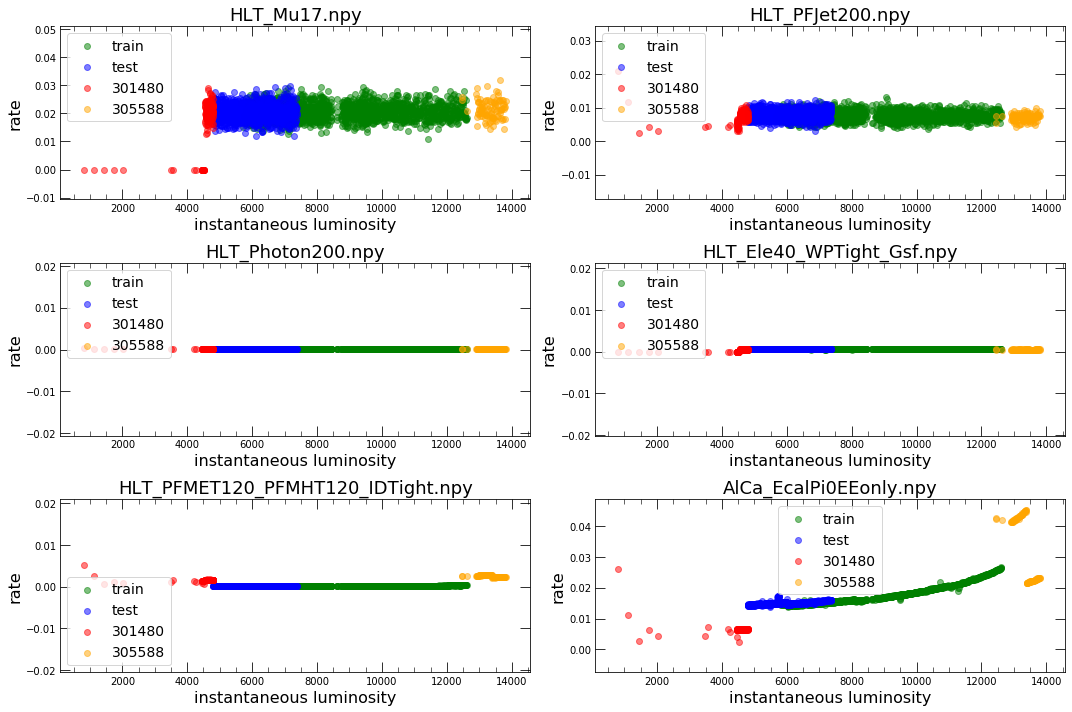

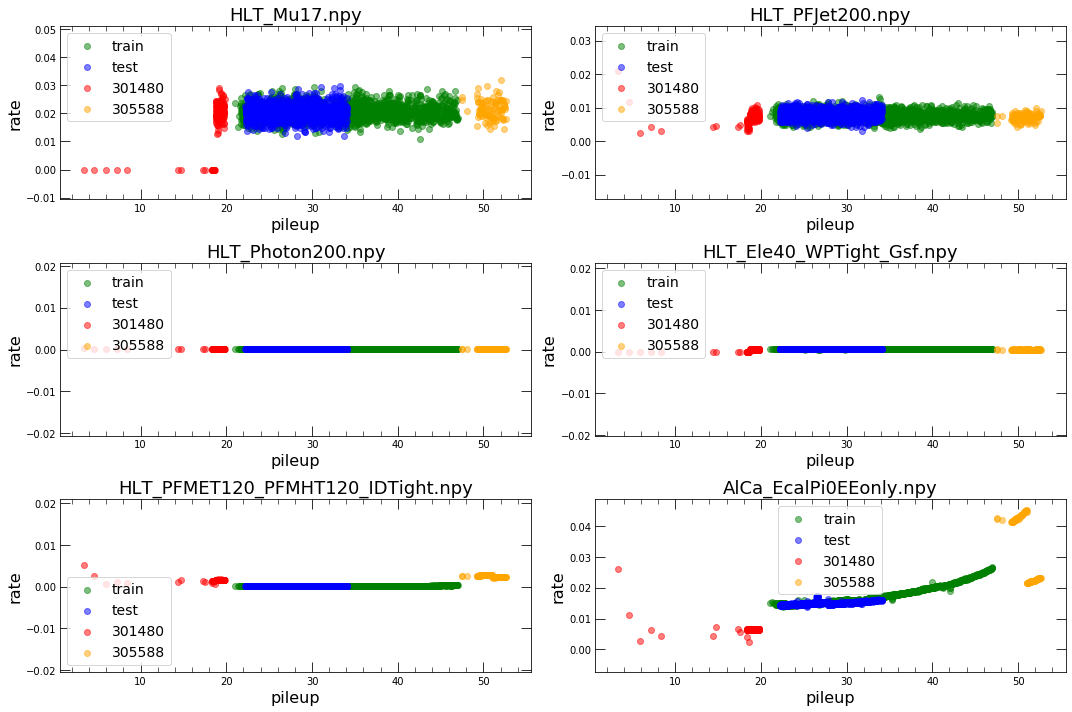

In [13]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [14]:
model_name = "simplest"


In [16]:
# Define the architecture

_input = Input(shape=(num_parts*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(num_parts*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 24        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1129 samples
Epoch 1/1000
 - 1s - loss: 0.0174 - val_loss: 0.0154
Epoch 2/1000
 - 0s - loss: 0.0170 - val_loss: 0.0150
Epoch 3/1000
 - 0s - loss: 0.0166 - val_loss: 0.0147
Epoch 4/1000
 - 0s - loss: 0.0162 - val_loss: 0.0143
Epoch 5/1000
 - 0s - loss: 0.0157 - val_loss: 0.0139
Epoch 6/1000
 - 0s - loss: 0.0153 - val_loss: 0.0136
Epoch 7/1000
 - 0s - loss: 0.0149 - val_loss: 0.0132
Epoch 8/1000
 - 0s - loss: 0.0146 - val_loss: 0.0129
Epoch 9/1000
 - 0s - loss: 0.0142 - val_loss: 0.0125
Epoch 10/1000
 - 0s - loss: 0.0138 - val_loss: 0.0122
Epoch 11/1000
 - 0s - loss: 0.0135 - val_loss: 0.0119
Epoch 12/1000
 - 0s - loss: 0.0131 - val_loss: 0.0116
Epoch 13/1000
 - 0s - loss: 0.0128 - val_loss: 0.0113
Epoch 14/1000
 - 0s - loss: 0.0124 - val_loss: 0.0110
Epoch 15/1000
 - 0s - loss: 0.0121 - val_loss: 0.0107
Epoch 16/1000
 - 0s - loss: 0.0118 - val_loss: 0.0104
Epoch 17/1000
 - 0s - loss: 0.0115 - val_loss: 0.0102
Epoch 18/1000
 - 0s - loss: 0.0112 - val_lo

Epoch 149/1000
 - 0s - loss: 7.9503e-04 - val_loss: 7.0774e-04
Epoch 150/1000
 - 0s - loss: 7.8293e-04 - val_loss: 6.9698e-04
Epoch 151/1000
 - 0s - loss: 7.7103e-04 - val_loss: 6.8642e-04
Epoch 152/1000
 - 0s - loss: 7.5940e-04 - val_loss: 6.7606e-04
Epoch 153/1000
 - 0s - loss: 7.4797e-04 - val_loss: 6.6589e-04
Epoch 154/1000
 - 0s - loss: 7.3676e-04 - val_loss: 6.5590e-04
Epoch 155/1000
 - 0s - loss: 7.2572e-04 - val_loss: 6.4610e-04
Epoch 156/1000
 - 0s - loss: 7.1493e-04 - val_loss: 6.3648e-04
Epoch 157/1000
 - 0s - loss: 7.0431e-04 - val_loss: 6.2704e-04
Epoch 158/1000
 - 0s - loss: 6.9389e-04 - val_loss: 6.1777e-04
Epoch 159/1000
 - 0s - loss: 6.8366e-04 - val_loss: 6.0867e-04
Epoch 160/1000
 - 0s - loss: 6.7363e-04 - val_loss: 5.9973e-04
Epoch 161/1000
 - 0s - loss: 6.6374e-04 - val_loss: 5.9095e-04
Epoch 162/1000
 - 0s - loss: 6.5407e-04 - val_loss: 5.8234e-04
Epoch 163/1000
 - 0s - loss: 6.4456e-04 - val_loss: 5.7387e-04
Epoch 164/1000
 - 0s - loss: 6.3522e-04 - val_loss: 5.6

Epoch 280/1000
 - 0s - loss: 1.5580e-04 - val_loss: 1.3829e-04
Epoch 281/1000
 - 0s - loss: 1.5424e-04 - val_loss: 1.3690e-04
Epoch 282/1000
 - 0s - loss: 1.5270e-04 - val_loss: 1.3553e-04
Epoch 283/1000
 - 0s - loss: 1.5118e-04 - val_loss: 1.3417e-04
Epoch 284/1000
 - 0s - loss: 1.4968e-04 - val_loss: 1.3284e-04
Epoch 285/1000
 - 0s - loss: 1.4820e-04 - val_loss: 1.3152e-04
Epoch 286/1000
 - 0s - loss: 1.4674e-04 - val_loss: 1.3021e-04
Epoch 287/1000
 - 0s - loss: 1.4531e-04 - val_loss: 1.2892e-04
Epoch 288/1000
 - 0s - loss: 1.4388e-04 - val_loss: 1.2765e-04
Epoch 289/1000
 - 0s - loss: 1.4247e-04 - val_loss: 1.2640e-04
Epoch 290/1000
 - 0s - loss: 1.4109e-04 - val_loss: 1.2516e-04
Epoch 291/1000
 - 0s - loss: 1.3972e-04 - val_loss: 1.2394e-04
Epoch 292/1000
 - 0s - loss: 1.3836e-04 - val_loss: 1.2273e-04
Epoch 293/1000
 - 0s - loss: 1.3703e-04 - val_loss: 1.2154e-04
Epoch 294/1000
 - 0s - loss: 1.3571e-04 - val_loss: 1.2036e-04
Epoch 295/1000
 - 0s - loss: 1.3441e-04 - val_loss: 1.1

Epoch 411/1000
 - 0s - loss: 5.1464e-05 - val_loss: 4.4892e-05
Epoch 412/1000
 - 0s - loss: 5.1091e-05 - val_loss: 4.4555e-05
Epoch 413/1000
 - 0s - loss: 5.0722e-05 - val_loss: 4.4222e-05
Epoch 414/1000
 - 0s - loss: 5.0356e-05 - val_loss: 4.3892e-05
Epoch 415/1000
 - 0s - loss: 4.9994e-05 - val_loss: 4.3564e-05
Epoch 416/1000
 - 0s - loss: 4.9635e-05 - val_loss: 4.3240e-05
Epoch 417/1000
 - 0s - loss: 4.9278e-05 - val_loss: 4.2918e-05
Epoch 418/1000
 - 0s - loss: 4.8925e-05 - val_loss: 4.2600e-05
Epoch 419/1000
 - 0s - loss: 4.8575e-05 - val_loss: 4.2284e-05
Epoch 420/1000
 - 0s - loss: 4.8229e-05 - val_loss: 4.1971e-05
Epoch 421/1000
 - 0s - loss: 4.7885e-05 - val_loss: 4.1661e-05
Epoch 422/1000
 - 0s - loss: 4.7545e-05 - val_loss: 4.1354e-05
Epoch 423/1000
 - 0s - loss: 4.7207e-05 - val_loss: 4.1049e-05
Epoch 424/1000
 - 0s - loss: 4.6872e-05 - val_loss: 4.0748e-05
Epoch 425/1000
 - 0s - loss: 4.6541e-05 - val_loss: 4.0448e-05
Epoch 426/1000
 - 0s - loss: 4.6212e-05 - val_loss: 4.0

Epoch 542/1000
 - 0s - loss: 2.1562e-05 - val_loss: 1.8442e-05
Epoch 543/1000
 - 0s - loss: 2.1430e-05 - val_loss: 1.8327e-05
Epoch 544/1000
 - 0s - loss: 2.1299e-05 - val_loss: 1.8214e-05
Epoch 545/1000
 - 0s - loss: 2.1168e-05 - val_loss: 1.8101e-05
Epoch 546/1000
 - 0s - loss: 2.1039e-05 - val_loss: 1.7989e-05
Epoch 547/1000
 - 0s - loss: 2.0910e-05 - val_loss: 1.7879e-05
Epoch 548/1000
 - 0s - loss: 2.0782e-05 - val_loss: 1.7769e-05
Epoch 549/1000
 - 0s - loss: 2.0656e-05 - val_loss: 1.7659e-05
Epoch 550/1000
 - 0s - loss: 2.0530e-05 - val_loss: 1.7550e-05
Epoch 551/1000
 - 0s - loss: 2.0405e-05 - val_loss: 1.7441e-05
Epoch 552/1000
 - 0s - loss: 2.0280e-05 - val_loss: 1.7332e-05
Epoch 553/1000
 - 0s - loss: 2.0157e-05 - val_loss: 1.7225e-05
Epoch 554/1000
 - 0s - loss: 2.0035e-05 - val_loss: 1.7118e-05
Epoch 555/1000
 - 0s - loss: 1.9914e-05 - val_loss: 1.7011e-05
Epoch 556/1000
 - 0s - loss: 1.9793e-05 - val_loss: 1.6905e-05
Epoch 557/1000
 - 0s - loss: 1.9673e-05 - val_loss: 1.6

Epoch 673/1000
 - 0s - loss: 1.0134e-05 - val_loss: 8.5279e-06
Epoch 674/1000
 - 0s - loss: 1.0079e-05 - val_loss: 8.4822e-06
Epoch 675/1000
 - 0s - loss: 1.0025e-05 - val_loss: 8.4371e-06
Epoch 676/1000
 - 0s - loss: 9.9719e-06 - val_loss: 8.3915e-06
Epoch 677/1000
 - 0s - loss: 9.9187e-06 - val_loss: 8.3460e-06
Epoch 678/1000
 - 0s - loss: 9.8659e-06 - val_loss: 8.3003e-06
Epoch 679/1000
 - 0s - loss: 9.8133e-06 - val_loss: 8.2541e-06
Epoch 680/1000
 - 0s - loss: 9.7611e-06 - val_loss: 8.2076e-06
Epoch 681/1000
 - 0s - loss: 9.7093e-06 - val_loss: 8.1606e-06
Epoch 682/1000
 - 0s - loss: 9.6578e-06 - val_loss: 8.1139e-06
Epoch 683/1000
 - 0s - loss: 9.6068e-06 - val_loss: 8.0697e-06
Epoch 684/1000
 - 0s - loss: 9.5558e-06 - val_loss: 8.0249e-06
Epoch 685/1000
 - 0s - loss: 9.5054e-06 - val_loss: 7.9811e-06
Epoch 686/1000
 - 0s - loss: 9.4552e-06 - val_loss: 7.9379e-06
Epoch 687/1000
 - 0s - loss: 9.4053e-06 - val_loss: 7.8949e-06
Epoch 688/1000
 - 0s - loss: 9.3558e-06 - val_loss: 7.8

Epoch 804/1000
 - 0s - loss: 5.3160e-06 - val_loss: 4.3801e-06
Epoch 805/1000
 - 0s - loss: 5.2925e-06 - val_loss: 4.3601e-06
Epoch 806/1000
 - 0s - loss: 5.2693e-06 - val_loss: 4.3407e-06
Epoch 807/1000
 - 0s - loss: 5.2461e-06 - val_loss: 4.3208e-06
Epoch 808/1000
 - 0s - loss: 5.2230e-06 - val_loss: 4.2996e-06
Epoch 809/1000
 - 0s - loss: 5.2002e-06 - val_loss: 4.2790e-06
Epoch 810/1000
 - 0s - loss: 5.1774e-06 - val_loss: 4.2580e-06
Epoch 811/1000
 - 0s - loss: 5.1548e-06 - val_loss: 4.2382e-06
Epoch 812/1000
 - 0s - loss: 5.1324e-06 - val_loss: 4.2189e-06
Epoch 813/1000
 - 0s - loss: 5.1101e-06 - val_loss: 4.2003e-06
Epoch 814/1000
 - 0s - loss: 5.0879e-06 - val_loss: 4.1819e-06
Epoch 815/1000
 - 0s - loss: 5.0659e-06 - val_loss: 4.1639e-06
Epoch 816/1000
 - 0s - loss: 5.0440e-06 - val_loss: 4.1464e-06
Epoch 817/1000
 - 0s - loss: 5.0223e-06 - val_loss: 4.1286e-06
Epoch 818/1000
 - 0s - loss: 5.0006e-06 - val_loss: 4.1114e-06
Epoch 819/1000
 - 0s - loss: 4.9792e-06 - val_loss: 4.0

Epoch 935/1000
 - 0s - loss: 3.2271e-06 - val_loss: 2.6061e-06
Epoch 936/1000
 - 0s - loss: 3.2170e-06 - val_loss: 2.5985e-06
Epoch 937/1000
 - 0s - loss: 3.2069e-06 - val_loss: 2.5911e-06
Epoch 938/1000
 - 0s - loss: 3.1970e-06 - val_loss: 2.5835e-06
Epoch 939/1000
 - 0s - loss: 3.1871e-06 - val_loss: 2.5767e-06
Epoch 940/1000
 - 0s - loss: 3.1773e-06 - val_loss: 2.5696e-06
Epoch 941/1000
 - 0s - loss: 3.1675e-06 - val_loss: 2.5619e-06
Epoch 942/1000
 - 0s - loss: 3.1579e-06 - val_loss: 2.5528e-06
Epoch 943/1000
 - 0s - loss: 3.1482e-06 - val_loss: 2.5443e-06
Epoch 944/1000
 - 0s - loss: 3.1386e-06 - val_loss: 2.5360e-06
Epoch 945/1000
 - 0s - loss: 3.1291e-06 - val_loss: 2.5284e-06
Epoch 946/1000
 - 0s - loss: 3.1197e-06 - val_loss: 2.5193e-06
Epoch 947/1000
 - 0s - loss: 3.1103e-06 - val_loss: 2.5104e-06
Epoch 948/1000
 - 0s - loss: 3.1010e-06 - val_loss: 2.5025e-06
Epoch 949/1000
 - 0s - loss: 3.0917e-06 - val_loss: 2.4942e-06
Epoch 950/1000
 - 0s - loss: 3.0825e-06 - val_loss: 2.4

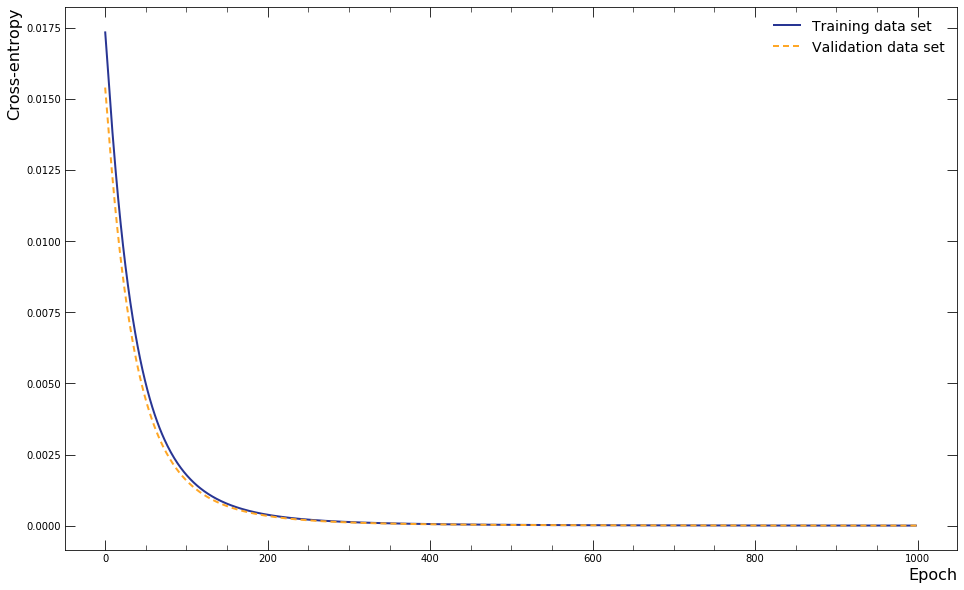

In [17]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

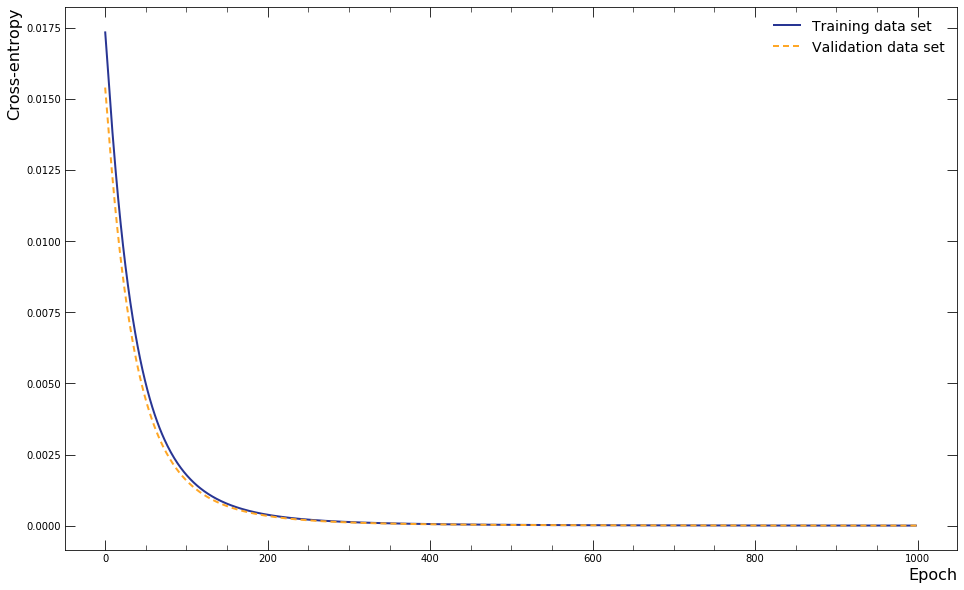

In [18]:
plot_loss(history)

## Training Set

In [19]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = (x_train_new-reconstructed)/x_train_new

In [20]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

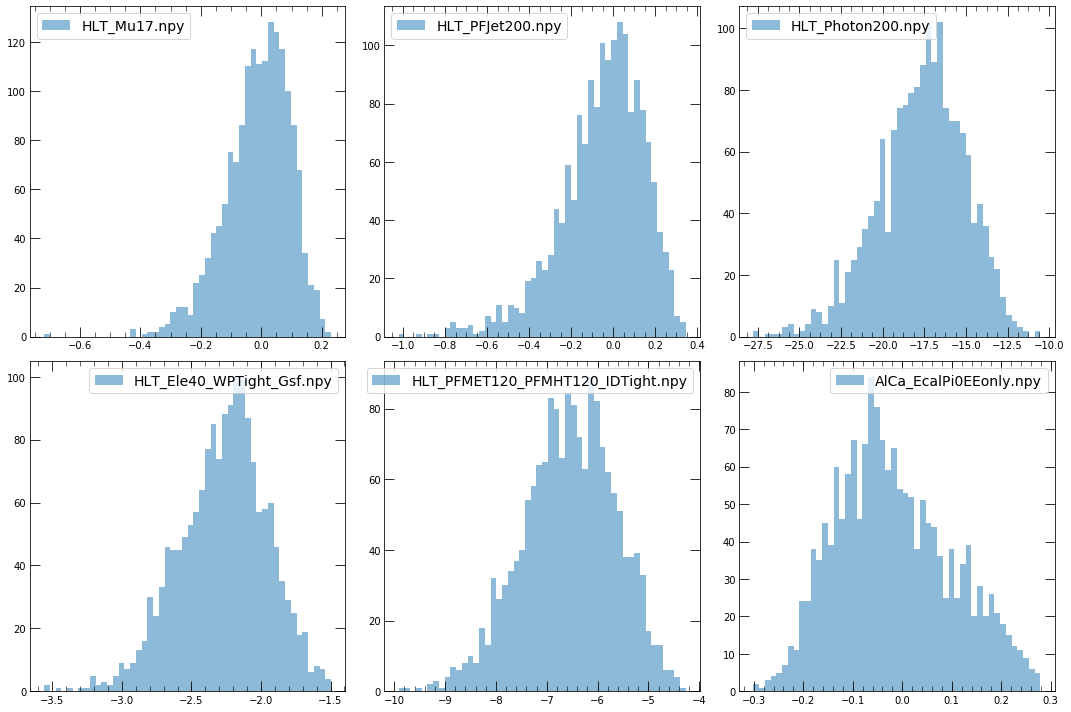

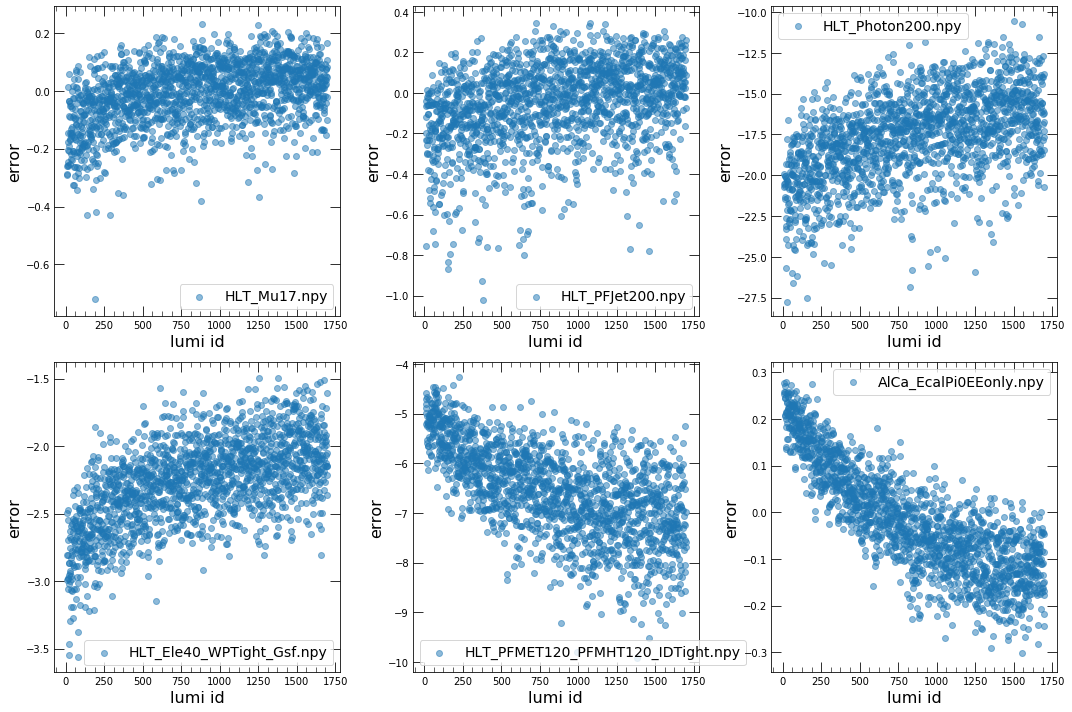

In [21]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()

plt.show()

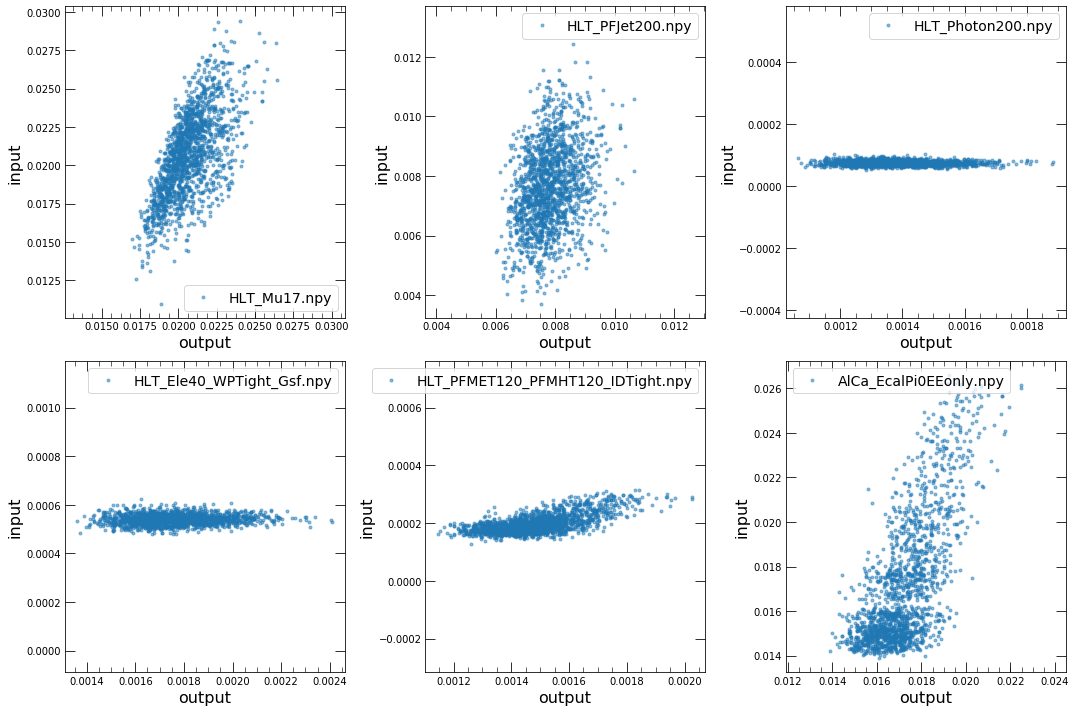

In [22]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    
plt.tight_layout()
plt.show()

## Test Data

In [43]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [44]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

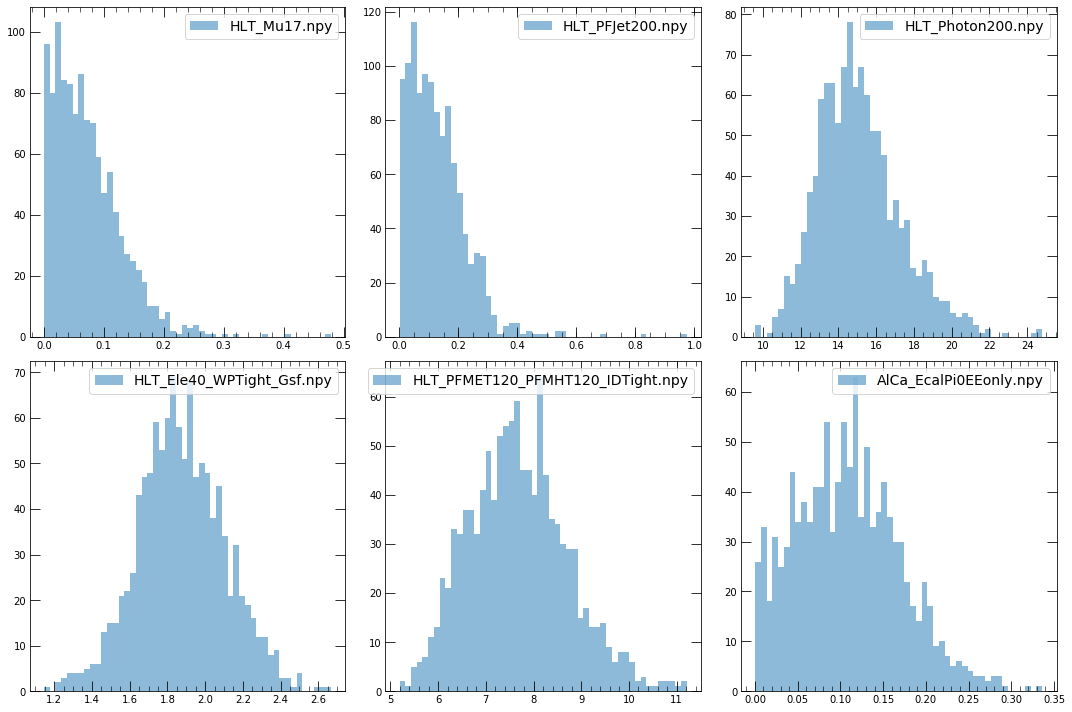

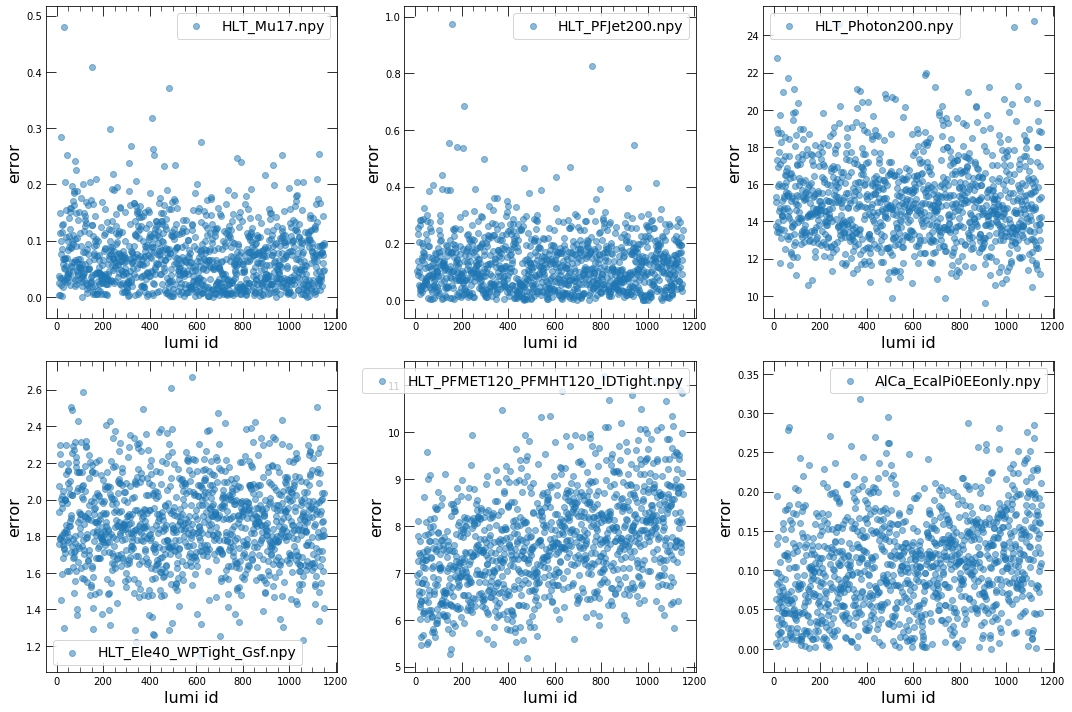

In [45]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()   
plt.tight_layout()

plt.show()

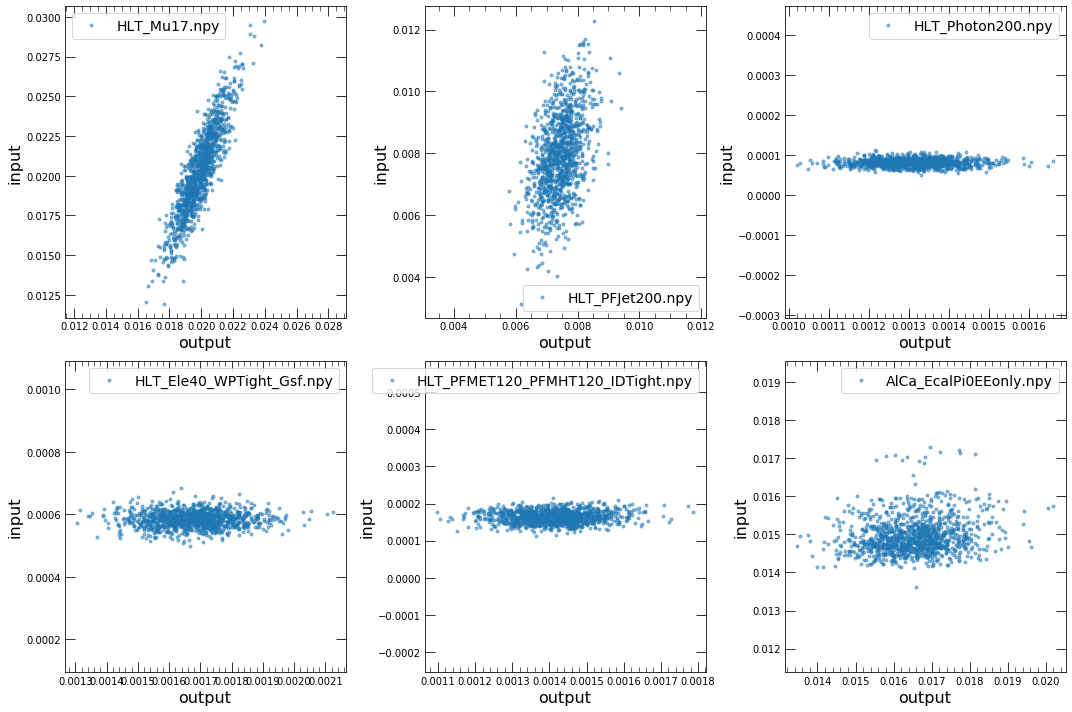

In [46]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    
    
plt.tight_layout()

plt.show()

In [47]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [48]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [49]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [50]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [51]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


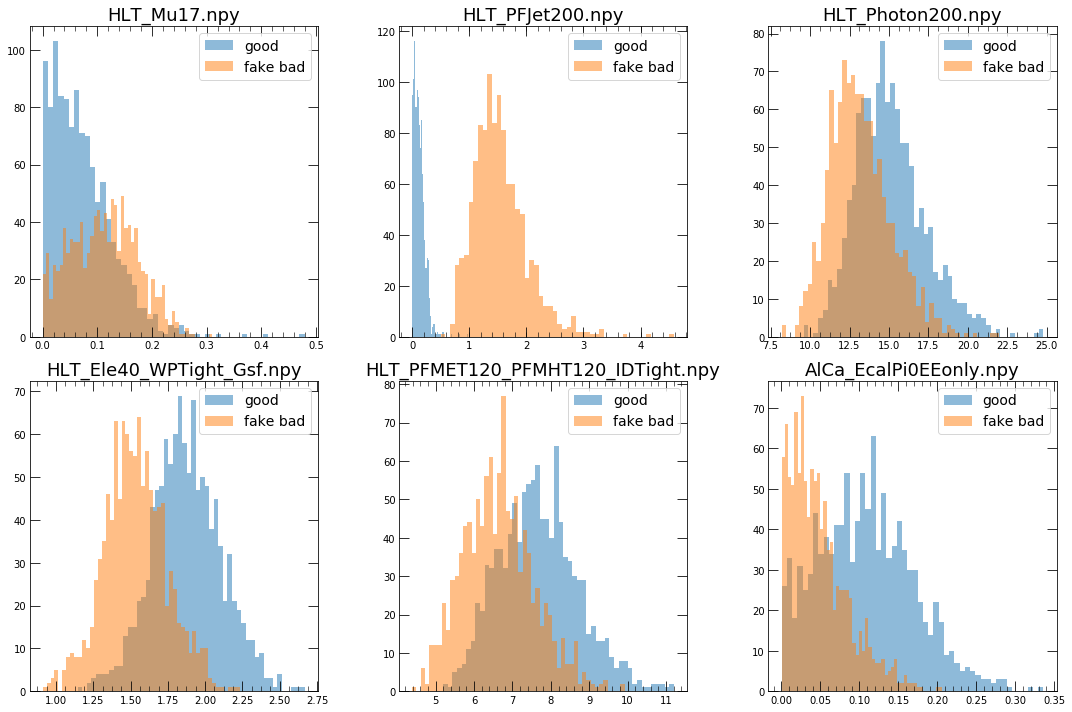

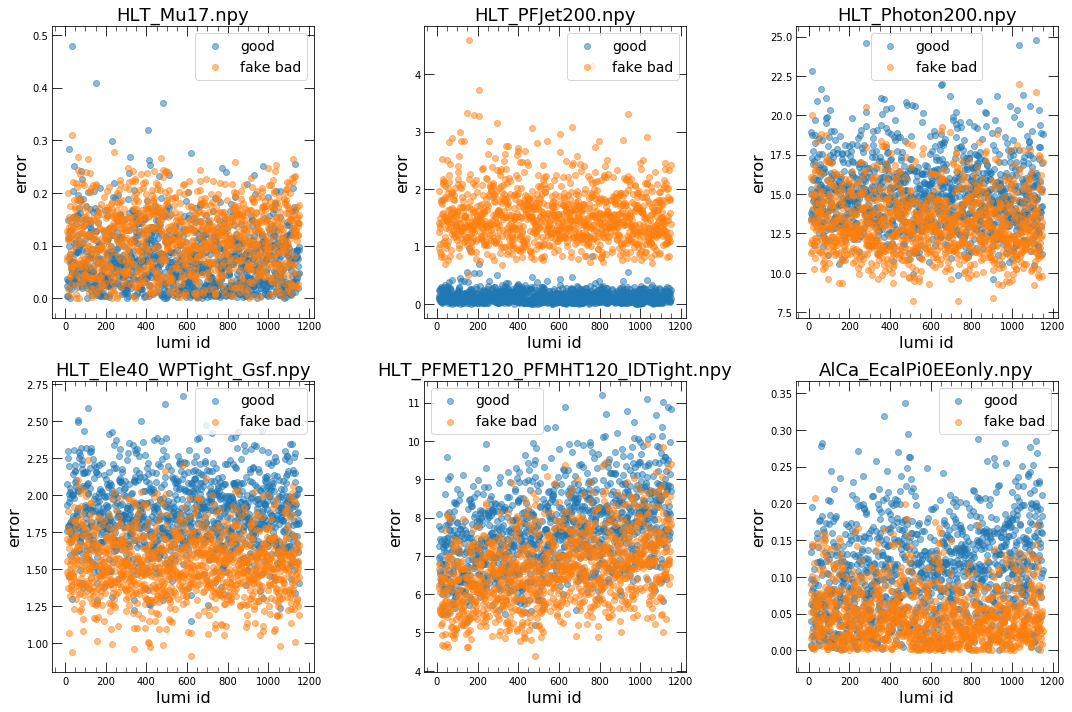

In [52]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

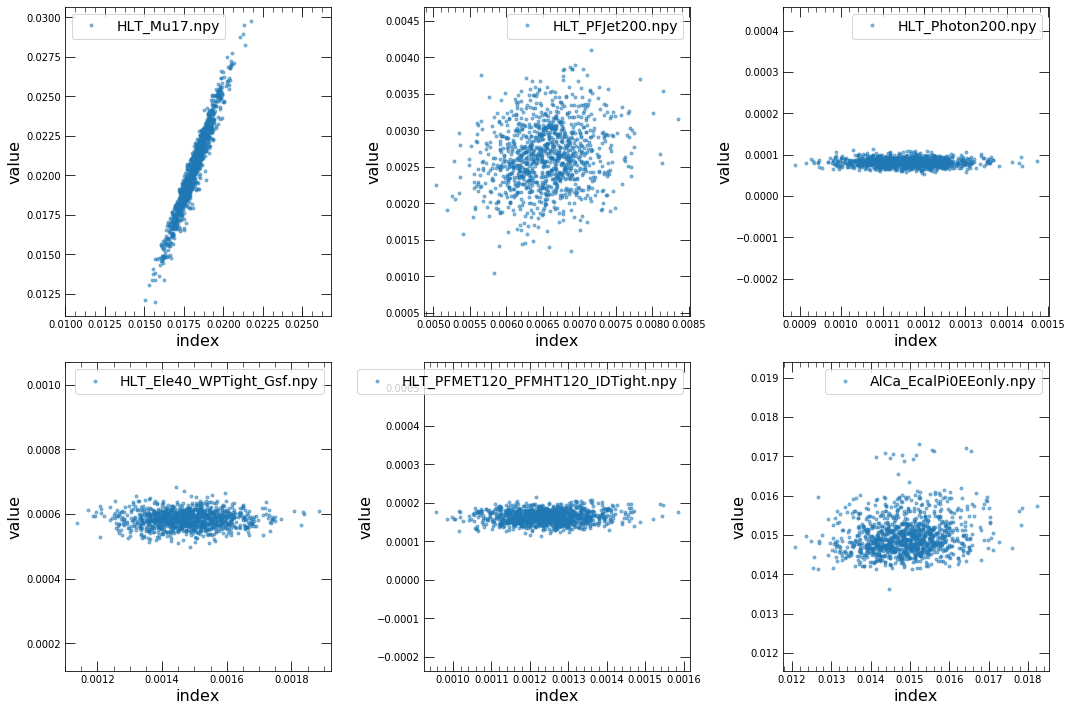

In [53]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [54]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [55]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [56]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [57]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [58]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


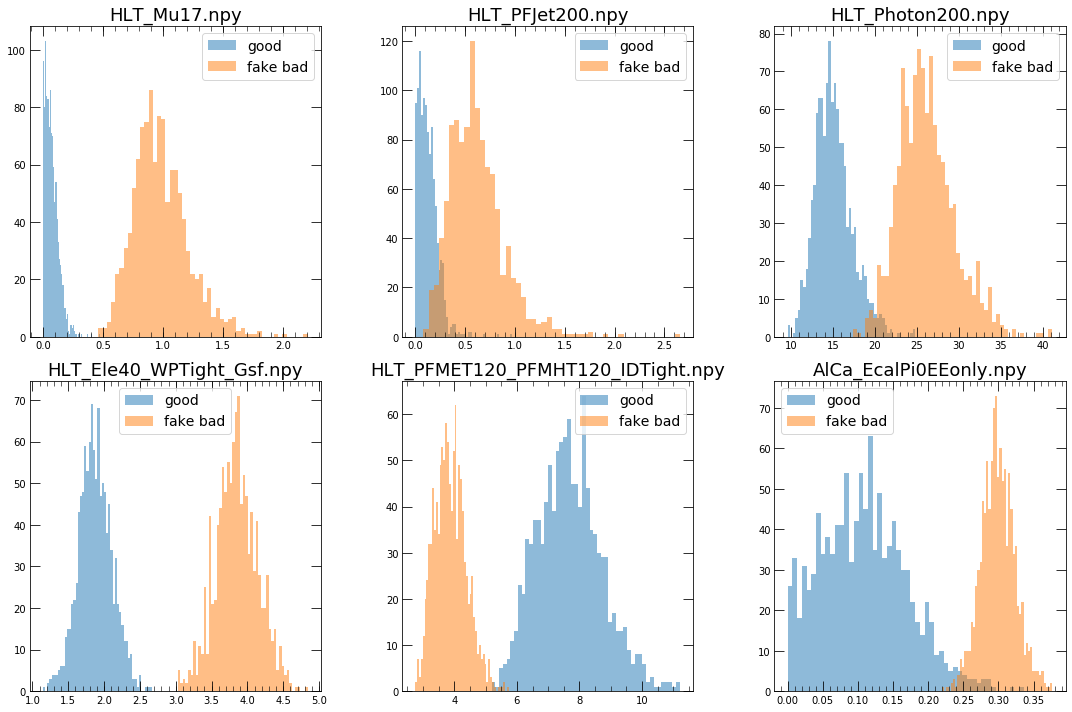

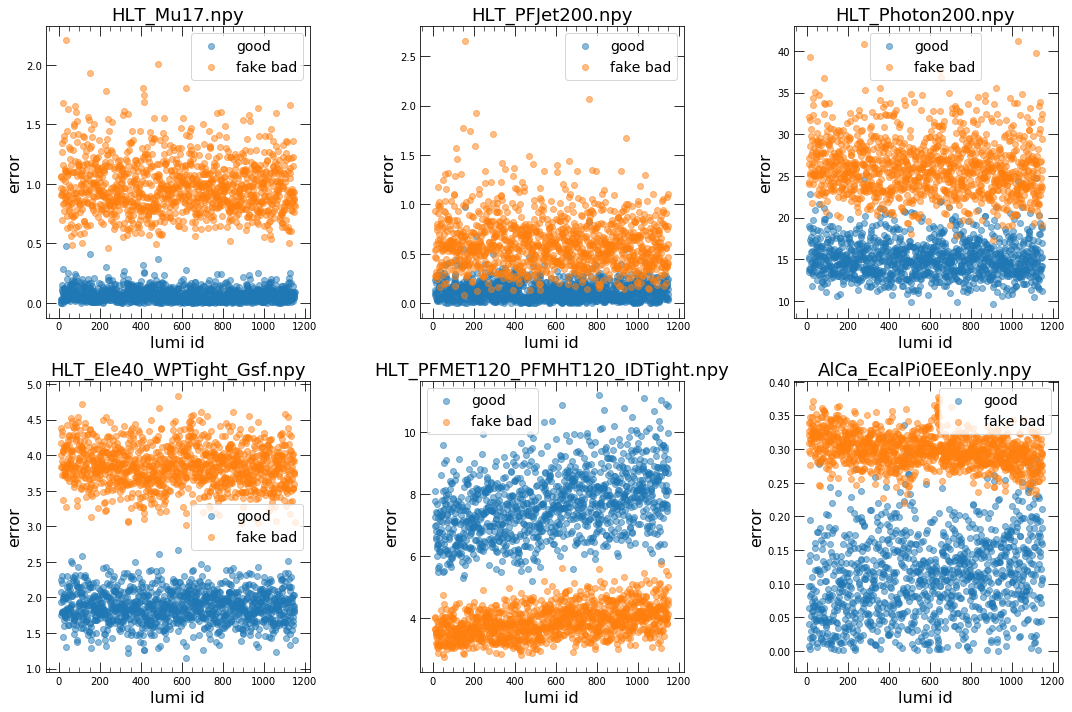

In [59]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

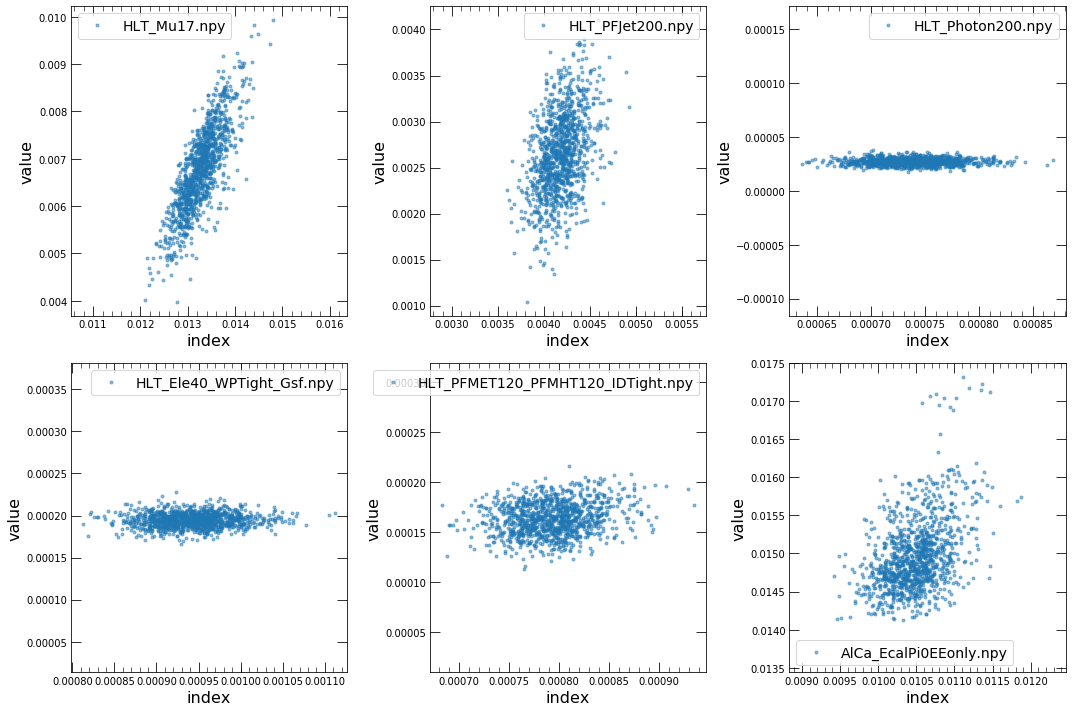

In [60]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [61]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [62]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [63]:
bad_runs = [301480]

with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [64]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [65]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


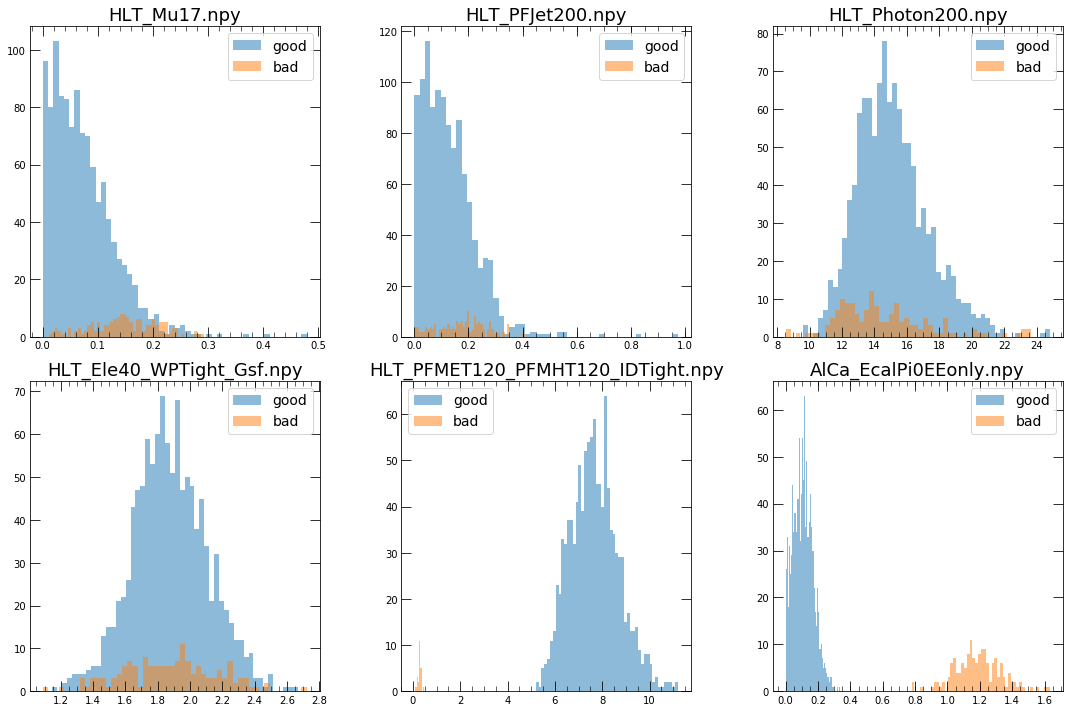

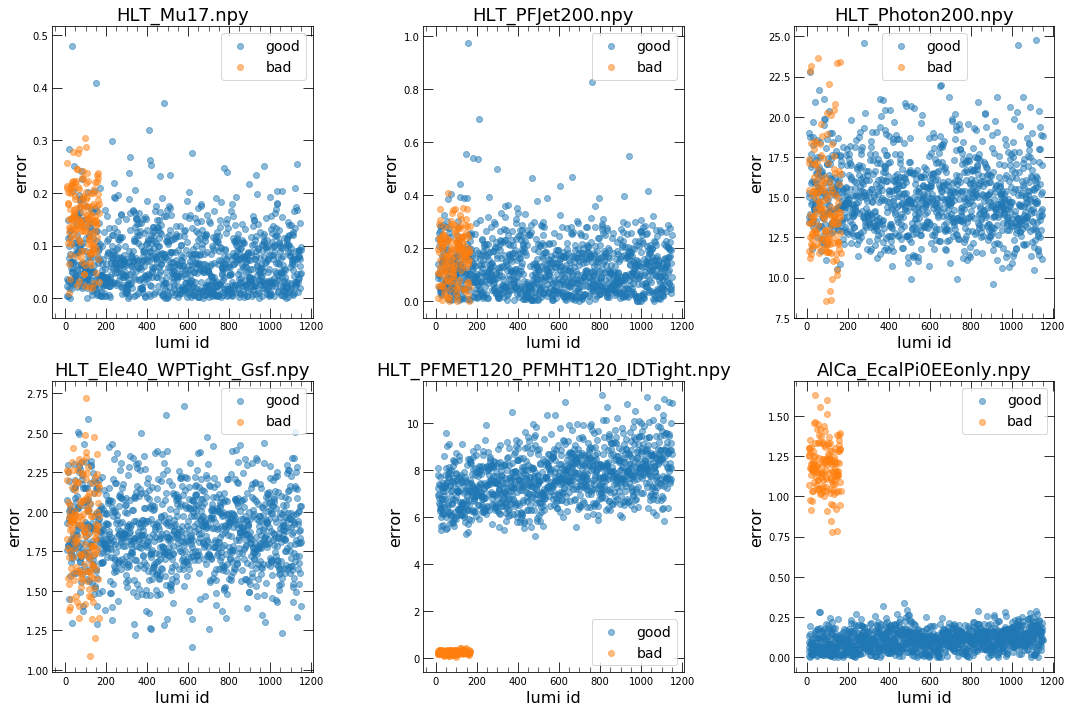

In [66]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

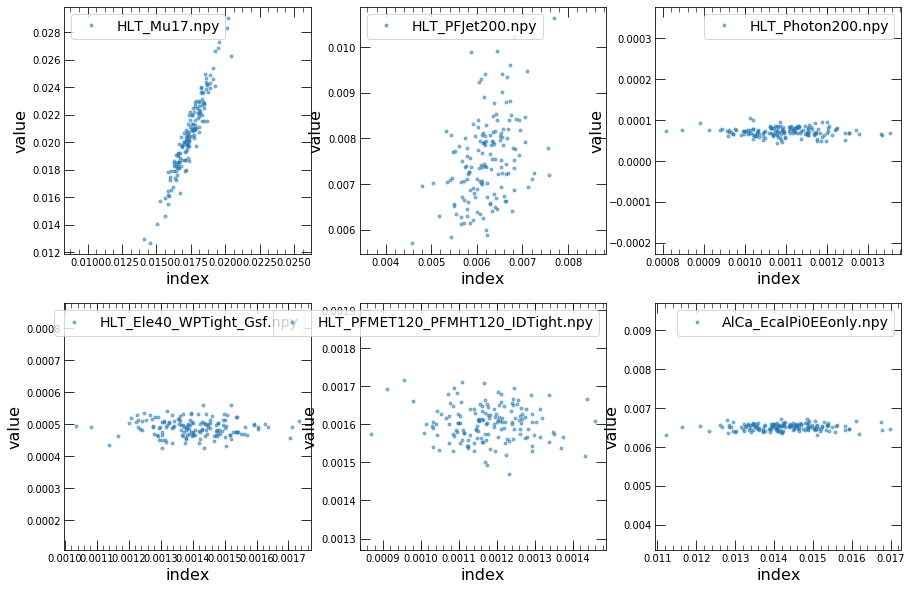

In [67]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [68]:
bad_runs = [305588]

with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [69]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [70]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


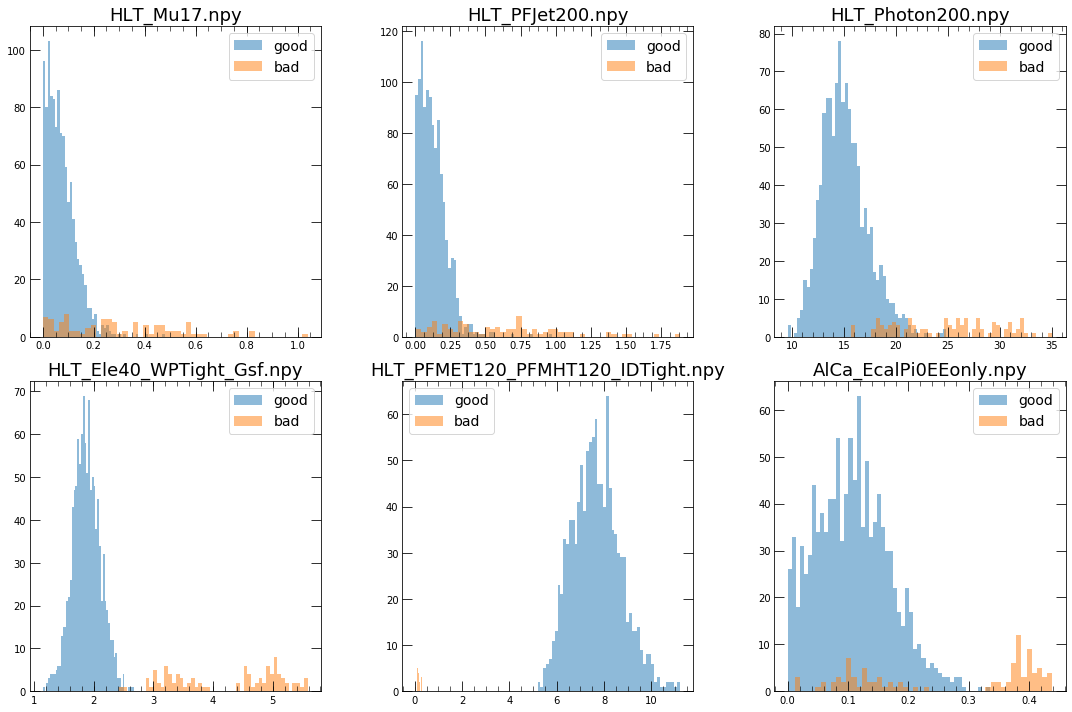

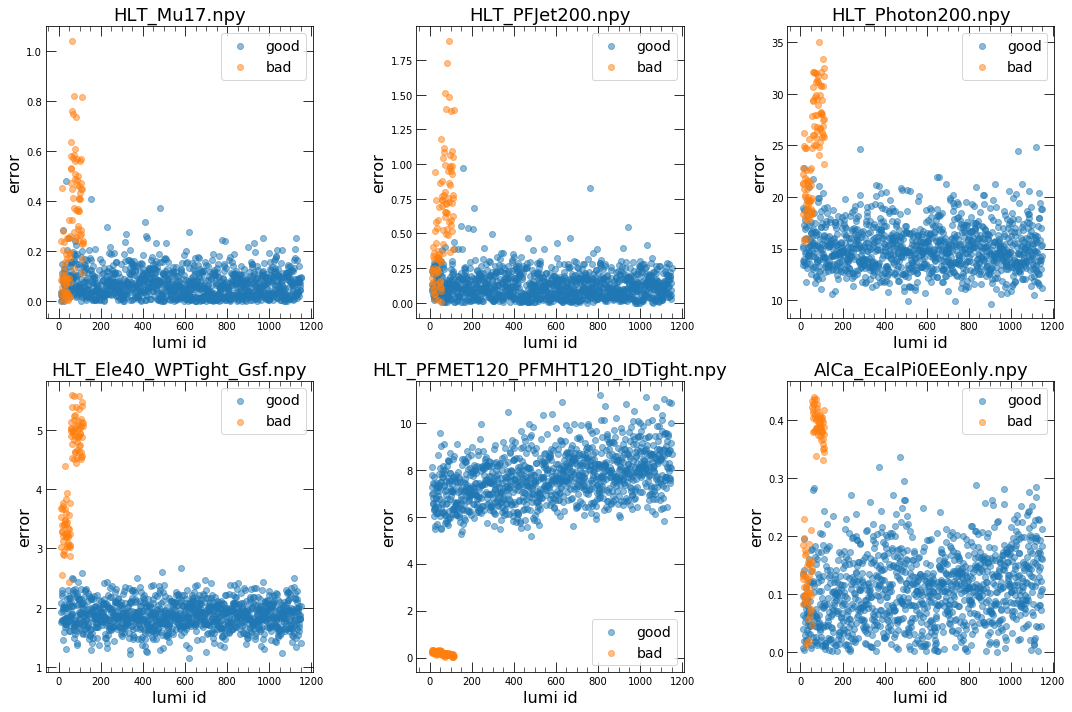

In [71]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

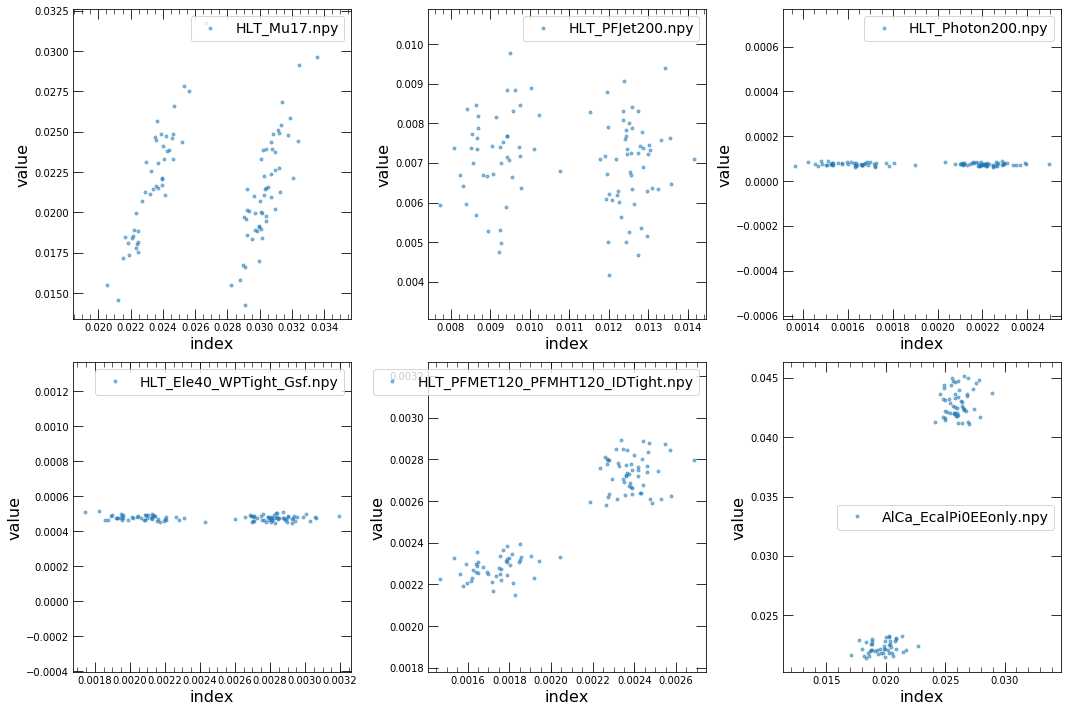

In [72]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()   
plt.tight_layout()

plt.show()